# 1. 从全连接到卷积

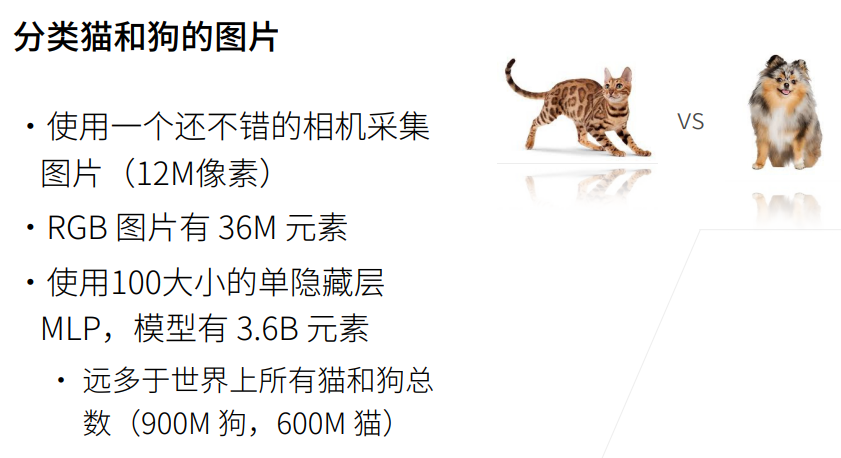

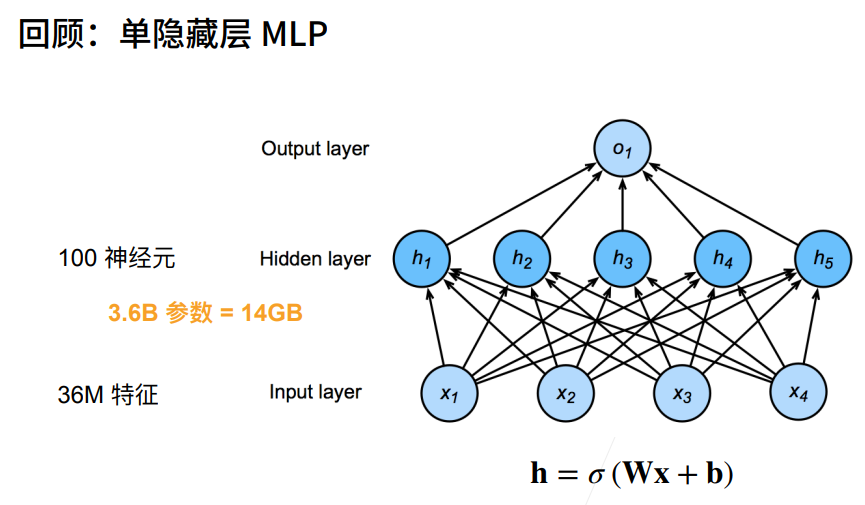

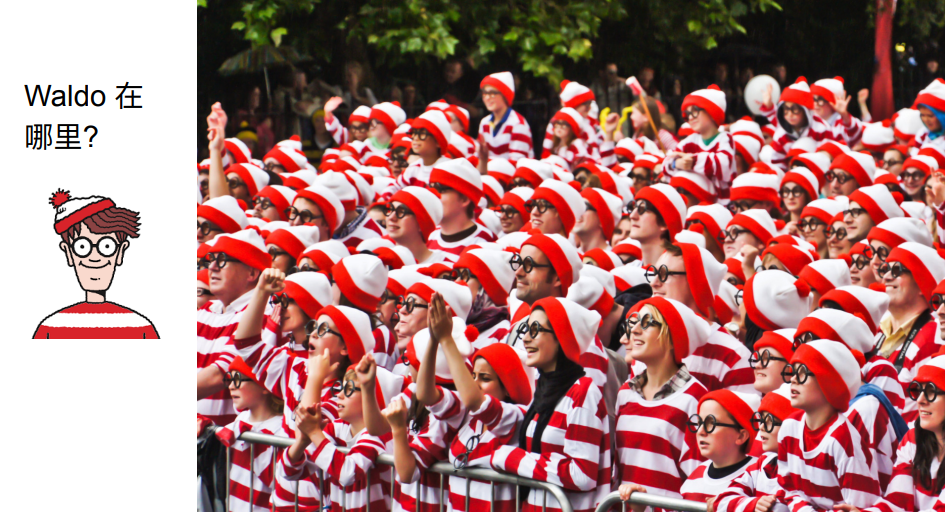

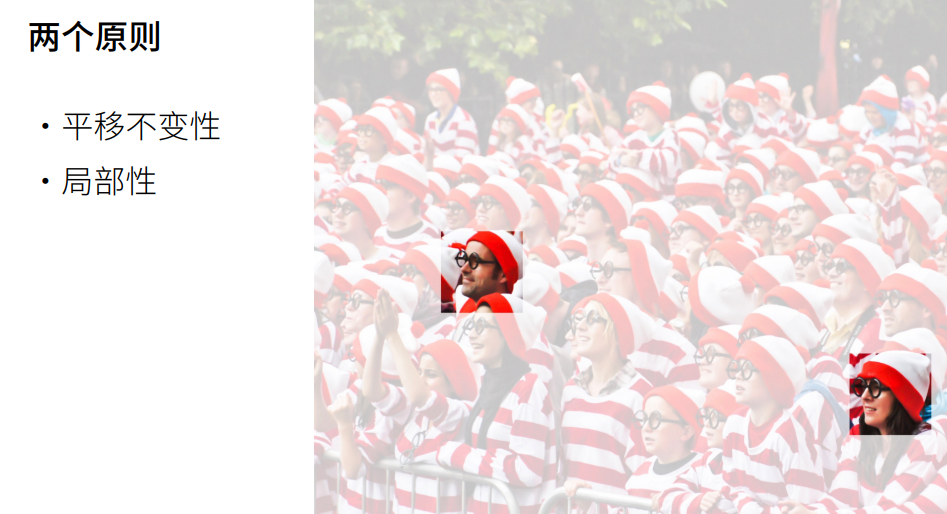

① k、l表示图片的第k行、第l列个像素，它相当于全连接层的$x_{i}$，$x_{i}$乘以一个权重值，得到全连接层中一层神经元中一个神经元的一条线的值。

② 有一个四维的W，里面有很多个w，例如前图的全连接层有100个w。i，j表示此w的坐标，即遍历所有的i、j合为100。每个w又是一个矩阵，每个w连接所有像素，对应矩阵宽高为k和l。因此下图中的$h_{i,j}$为全连接层中一个神经元的输出。

③ 原来的k,l是基于图片的绝对位置，ab是根据ij的相对位置，这里就省略绝对位置，只需要一个原点加相对原点的相对位置，就可以表示位置信息。

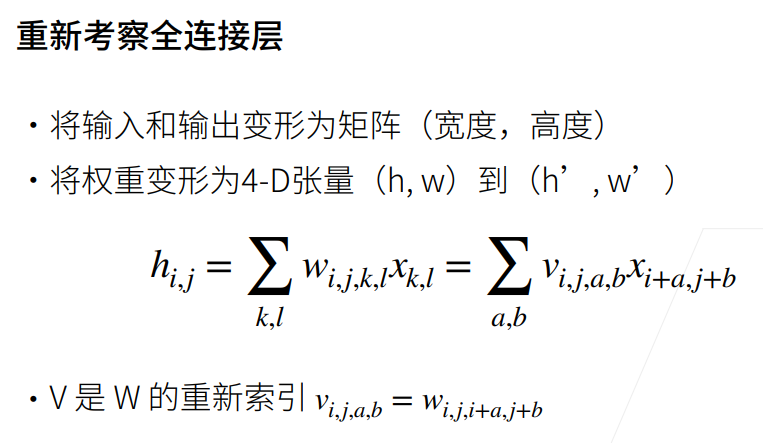

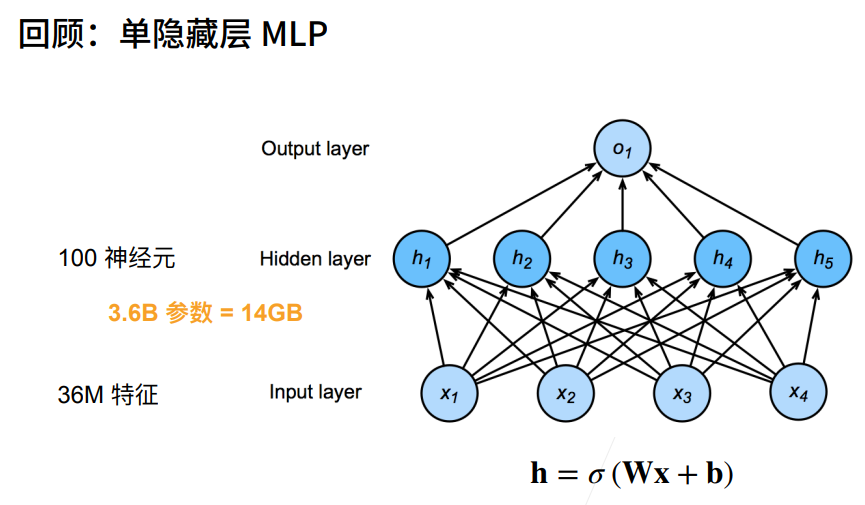

① 当在图片中形成一个识别器后，在一定像素大小的范围内，它都有自己的权重，当这个识别器在图片上换位置之后，它的权重应该不变。

② 理解成用同一张卷积核遍历整张图片。卷积核不会随着位置变化而变化。

③ 权重就是特征提取器，不应该随位置而发生变化。

④ 简而言之卷积核就是个框，在图片上不断扫描，无论扫在图上的哪个位置，卷积核都是不变的。

⑤ 对于一张图片应该有多个卷积核，但是每个卷积核要识别的东西不同，一个卷积核就是一个分类器。

⑥ 卷积确实是weight shared，但不是全联接，每个神经元是对应卷积核大小个输入。

⑦ 卷积就是weight shared全连接。

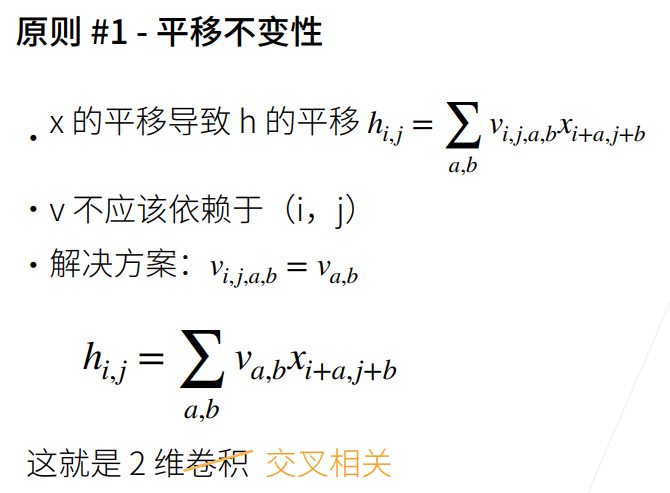

① 指取一个不那么大的框。

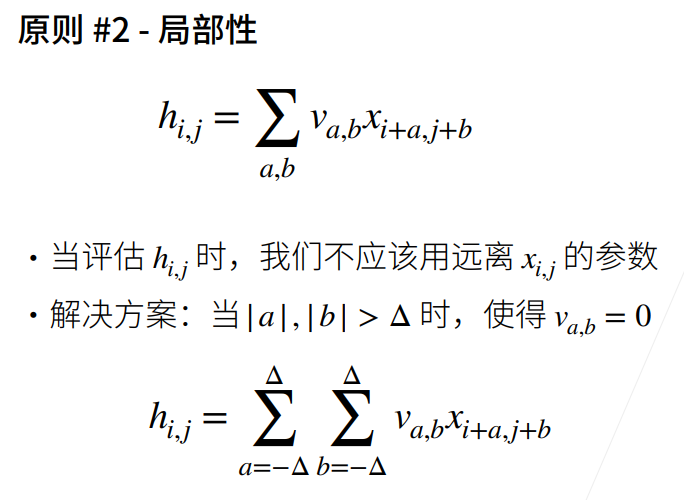

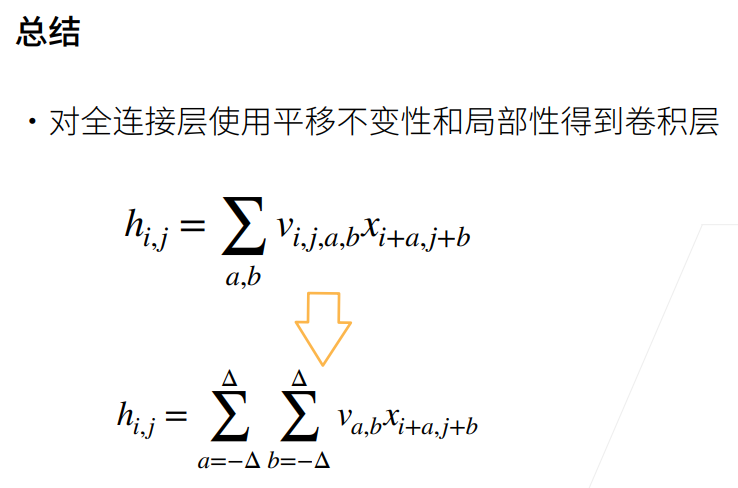

# 2. 卷积层

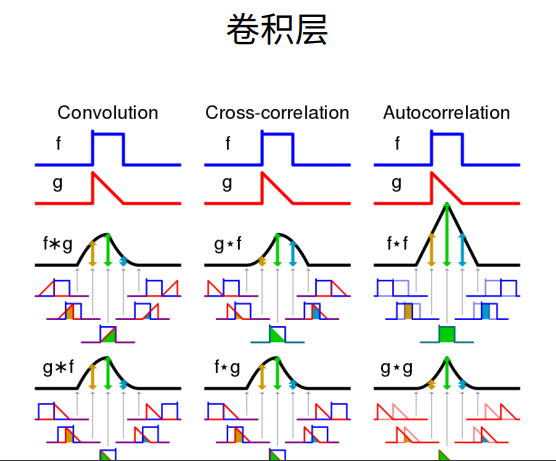

① 卷积核遇到和自己相似的，会极度膨胀，遇到和自己不一样的，会极度缩小。

② 提取图像特征，卷积层越深，提取的是语义的特征。

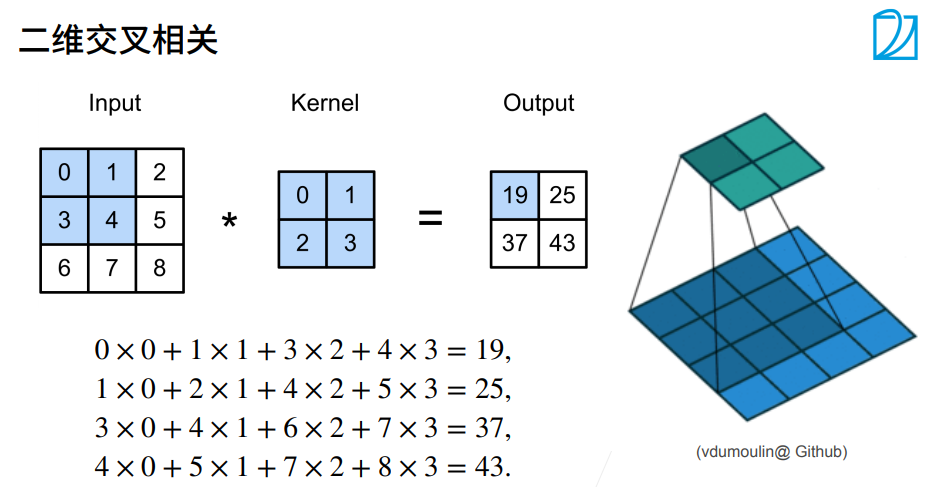

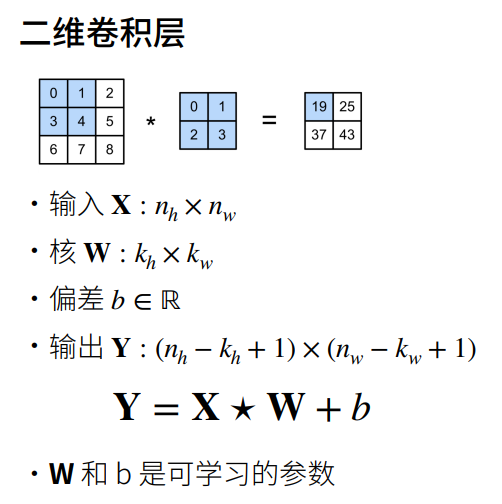

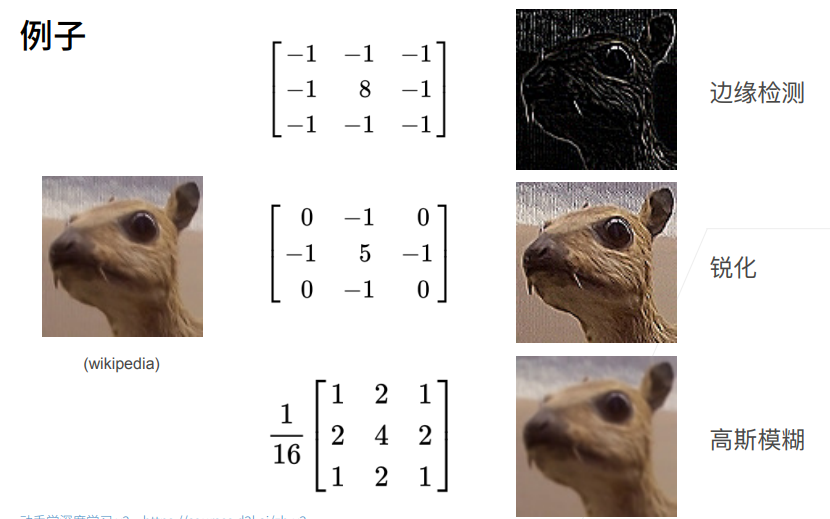

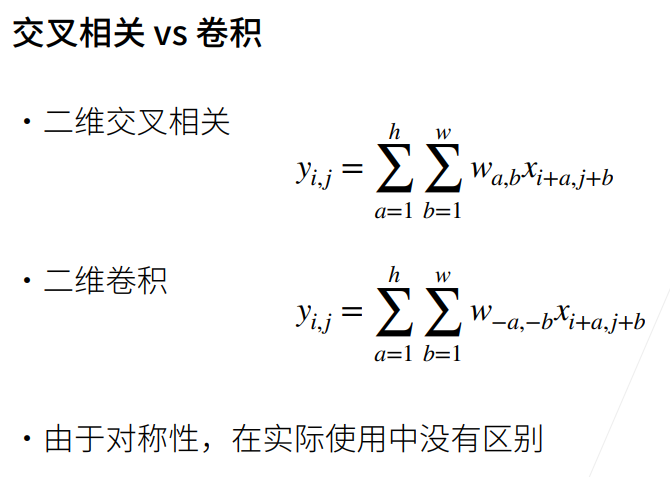

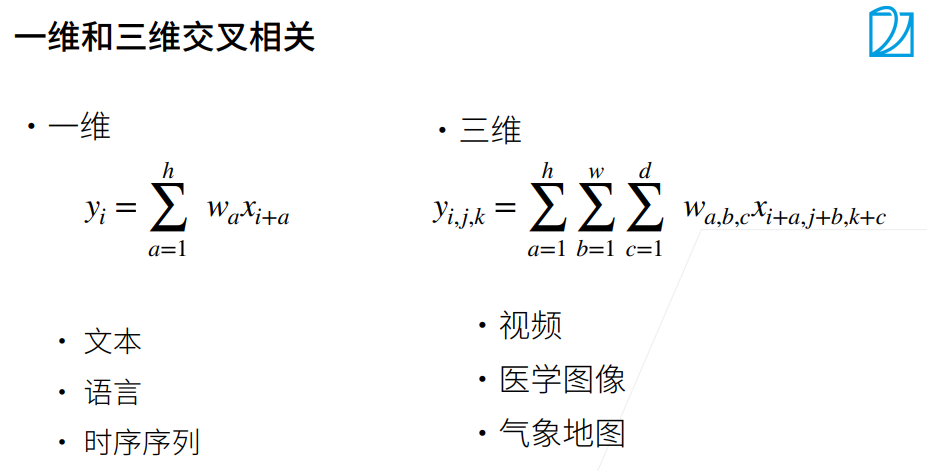

# 3. 总结

① 假如就是要看一个3 * 3的局部信息的话，卷积核就是一个 3 * 3 的矩阵，不会因为输入变得特别大导致权重变得特别大。

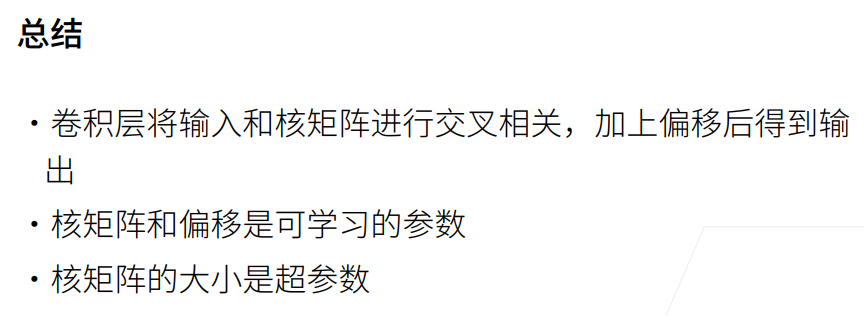

# 1. 卷积层操作（使用自定义）

In [1]:
# 互相关运算
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):   # X 为输入，K为核矩阵
    """计算二维互相关信息"""
    h, w = K.shape  # 核矩阵的行数和列数
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) # X.shape[0]为输入高    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum() # 图片的小方块区域与卷积核做点积
    return Y

# 验证上述二维互相关运算的输出
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

In [2]:
# 实现二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(Self, x):
        return corr2d(x, self.weight) + self.bias
    
# 卷积层的一个简单应用：检测图片中不同颜色的边缘
X = torch.ones((6,8))
X[:,2:6] = 0  # 把中间四列设置为0
print(X)  # 0 与 1 之间进行过渡，表示边缘

K = torch.tensor([[1.0,-1.0]])  # 如果左右原值相等，那么这两原值乘1和-1相加为0，则不是边缘
Y = corr2d(X, K)
print(Y)
print(corr2d(X.t(), K)) # X.t() 为X的转置，而K卷积核只能检测垂直边缘

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [3]:
# 学习由X生成Y的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1,2), bias=False) # 单个矩阵，输入通道为1，黑白图片通道为1，彩色图片通道为3。这里输入通道为1，输出通道为1.   
X = X.reshape((1,1,6,8)) # 通道维：通道数，RGB图3通道，灰度图1通道，批量维就是样本维，就是样本数
Y = Y.reshape((1,1,6,7))
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad # 3e-2是学习率
    if(i+1) % 2 == 0:
        print(f'batch {i+1},loss {l.sum():.3f}')

# 所学的卷积核的权重张量
print(conv2d.weight.data.reshape((1,2)))

batch 2,loss 9.914
batch 4,loss 3.107
batch 6,loss 1.113
batch 8,loss 0.429
batch 10,loss 0.171
tensor([[ 0.9473, -1.0320]])
